In [1]:
import sys
sys.path.append('/kaggle/input/bottleneck-package')
import bottleneck

import pandas as pd
import numpy as np
import os
import psutil  
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from pathlib import Path
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from functools import lru_cache
from pympler import asizeof

import typing
from dataclasses import dataclass
from collections.abc import Callable
from collections.abc import Sequence

import itertools
from tqdm import tqdm

2024-03-30 16:01:57.177425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 16:01:57.177514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 16:01:57.328189: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SUBMISSION = True
SUBMISSION = False
DEBUG = False
#DEBUG = True

VALIDATION_FRAC = 0.05
if SUBMISSION:
    DEBUG = False
    VALIDATION_FRAC = None
    
TRAIN_SIZE = 512 if DEBUG else None
SKIP_ASSERT = SUBMISSION or not DEBUG

In [3]:
USE_GPU = False 
USE_GPU = True

In [4]:
ADAM_LEARNING_RATE = 0.0001

In [5]:
%run -i '/kaggle/input/hms-share/data-utils.py'
%run -i '/kaggle/input/hms-share/eeg.py'
%run -i '/kaggle/input/hms-share/spectr.py'
%run -i '/kaggle/input/hms-share/target.py'
%run -i '/kaggle/input/hms-share/eeg_id.py'
%run -i '/kaggle/input/hms-share/data.py'

In [6]:
NUM_EPOCHS = 150
NUM_SUB_EPOCHS = 5 if not DEBUG else 2
BATCH_SIZE = 128

In [7]:
print('SUBMISSION =', SUBMISSION)
print('USE_GPU =', USE_GPU)
print('DEBUG = ', DEBUG)

SUBMISSION = False
USE_GPU = True
DEBUG =  False


In [8]:
def size_2_str(value):
    if value < 5 * 1024:
        return str(value) + ' bytes'
    if value < 5 * 1024 * 1024:
        return str(value//1024) + ' KB'
    return str(value//(1024*1024)) +' MB'

def get_mem_usage():
    pid = os.getpid()
    py = psutil.Process(pid)
    return py.memory_info()[0] // 2 ** 20

In [9]:
def create_eeg_model():
    input = keras.layers.Input(
        shape = (EEG.MODEL_WINDOW, len(EEG.FEATURES)), name = 'eeg.input'
    )
    model = keras.layers.Conv1D(
        filters = 29, kernel_size = 5, padding = 'valid', 
        name = 'eeg.1', data_format="channels_last", 
        activation = 'tanh'
    )(input)
    model = keras.layers.MaxPooling1D(
        pool_size = 7, strides = 3, name = 'eeg.1.max'
    )(model)
    model = keras.layers.Conv1D(
        filters = 29, kernel_size = 5, padding = 'valid', 
        name = 'eeg.2', data_format="channels_last", 
        activation = 'tanh'
    )(model)
    model = keras.layers.MaxPooling1D(
        pool_size = 7, strides = 3, name = 'eeg.2.max'
    )(model)
    model = keras.layers.Conv1D(
        filters = 31, kernel_size = 5, padding = 'valid', name = 'eeg.3',
        activation = 'tanh'
    )(model)
    model = keras.layers.MaxPooling1D(
        pool_size = 7, strides = 3, name = 'eeg.3.max'
    )(model)
    model = keras.layers.Conv1D(
        filters = 41, kernel_size = 5, padding = 'valid', name = 'eeg.4',
        activation = 'tanh'
    )(model)
    model = keras.layers.MaxPooling1D(
        pool_size = 7, strides = 3, name = 'eeg.4.max'
    )(model)
    model = keras.layers.Flatten(name = 'eeg.flatten')(model)
    model = keras.layers.Dropout(name = 'eeg.dropout.1', rate = 0.1)(model)
    model = keras.layers.Dense(
        units = 11, activation='relu', name = 'eeg.dense.1', 
    )(model)
    model = keras.layers.Dropout(name = 'eeg.dropout.2', rate = 0.1)(model)
    model = keras.layers.Dense(
        units = 11, activation='relu', name = 'eeg.dense.2', 
    )(model)
    model = keras.layers.Dense(
        units = len(Target.FEATURES), activation='softmax',name = 'eeg.output'
    )(model)
    model = keras.models.Model(inputs=input, outputs=model)
    return model    

In [10]:
#if USE_TPU:
#    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#    tf.tpu.experimental.initialize_tpu_system(tpu)
#    tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [11]:
def create_and_compile_model():
    model = create_eeg_model()
    optimizer = Adam(learning_rate = ADAM_LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg.input (InputLayer)      [(None, 1600, 20)]        0         
                                                                 
 eeg.1 (Conv1D)              (None, 1596, 29)          2929      
                                                                 
 eeg.1.max (MaxPooling1D)    (None, 530, 29)           0         
                                                                 
 eeg.2 (Conv1D)              (None, 526, 29)           4234      
                                                                 
 eeg.2.max (MaxPooling1D)    (None, 174, 29)           0         
                                                                 
 eeg.3 (Conv1D)              (None, 170, 31)           4526      
                                                                 
 eeg.3.max (MaxPooling1D)    (None, 55, 31)            0     

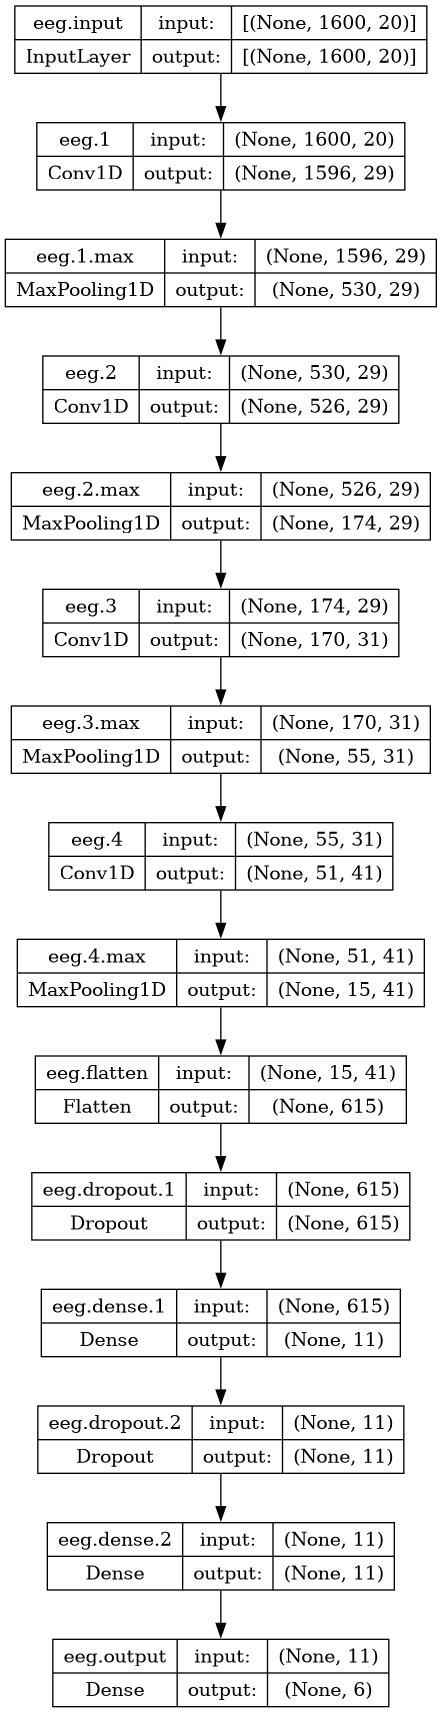

In [12]:
#if USE_TPU:
#    with tpu_strategy.scope():
#        model = create_and_compile_model()
#
#else:

model = create_and_compile_model()
model.summary()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [13]:
def build_train_data(
    ids, 
    eeg_loader, 
    target_loader
):
    eeg = EEG.create_model_input(ids, eeg_loader, BATCH_SIZE)
    target = Target.create_model_data(ids, target_loader, BATCH_SIZE)
    
    eeg_target = DataUtils.JoinSequence(eeg, target)
    return DataUtils.AsKerasSequence(eeg_target, lambda : random.shuffle(ids))
    

In [14]:
class EEGTrainLoader :
    CACHE_FILE = 'eeg_cache.npy'
    def __init__(self, train_info):
        self.data = pd.DataFrame(
            {
                c : DataUtils.decrease_int_type(train_info[c]) 
                for c in ['eeg_id','eeg_label_offset_seconds']
            }
        )
        try:
            self.cache = np.load(EEGTrainLoader.CACHE_FILE, 'r')
            if not len(self.cache) == len(self.data):
                raise ValueError('cache size invalid!')
        except Exception:
            self.cache = self.build_cache()
            print('Cache size =', size_2_str(asizeof.asizeof(self.cache)))
            np.save(EEGTrainLoader.CACHE_FILE, self.cache)
            self.cache = np.load(EEGTrainLoader.CACHE_FILE, 'r')
        print('Cache loaded, shape =', self.cache.shape)
                  
    def build_model_data(self, index):
        eeg_id, start = self.data.iloc[index] 
        start = start * EEG.FRAME_PER_SECOND
        end = start + EEG.FRAME
        data = EEG.load_train_frame(eeg_id)
        if not SKIP_ASSERT:
            assert start >=0 and start <= len(data), 'inlvalid start = {}, len = {}'.format(start, len(data))
            assert end <= len(data) and end >=0, 'invalid end = {}, len = {}'.format(end, len(data))
        data = EEG.filter_signals(data[EEG.FEATURES].iloc[start:end].to_numpy())
        return data.astype(dtype = np.float32)        
    
    def build_cache(self):
        return np.fromiter(
            [
                self.build_model_data(index) for index in tqdm(
                    range(len(self.data)),
                    desc = 'Build eeg cache'
                )
            ],
            dtype = (np.float32, (EEG.MODEL_WINDOW, len(EEG.FEATURES))),
            count = len(self.data)
        )

    @lru_cache(maxsize = None)
    def __call__(self, index):
        return self.cache[index]

In [15]:
train_size, train_eeg_loader, _, train_target_loader \
    = Data.load_train(TRAIN_SIZE)

train_info = Data.load_train_info(TRAIN_SIZE)
train_eeg_loader = EEGTrainLoader(train_info)

train_ids = list([x for x in range(train_size)])
if VALIDATION_FRAC > 0:
    train_ids, valid_ids = train_test_split(train_ids, test_size = VALIDATION_FRAC)
    
train_data = build_train_data(train_ids, train_eeg_loader, train_target_loader)
if VALIDATION_FRAC > 0:
    valid_data = build_train_data(valid_ids, train_eeg_loader, train_target_loader) 
else:
    valid_data = None    
train_data = DataUtils.SplitSubEpoches(train_data, NUM_SUB_EPOCHS)

Build eeg cache: 100%|██████████| 106800/106800 [26:54<00:00, 66.13it/s]


Cache size = 13037 MB
Cache loaded, shape = (106800, 1600, 20)


In [16]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [17]:
%%time

def fit_model(model, train_data, epochs, validation_data):
    if USE_GPU:
        with tf.device('/gpu:0'):
            return model.fit(
                train_data, 
                epochs = epochs, 
                validation_data = validation_data)
    else:
        return model.fit(
            train_data, 
            epochs = epochs, 
            validation_data = validation_data)
        
history = fit_model(
    model,
    train_data, 
    NUM_EPOCHS * NUM_SUB_EPOCHS, 
    valid_data
)

Epoch 1/750


I0000 00:00:1711816233.467882      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 [==============================] - 56s 301ms/step - loss: 1.7590 - acc: 0.1956 - val_loss: 1.7237 - val_acc: 0.2463
Epoch 2/750
159/159 [==============================] - 25s 156ms/step - loss: 1.7121 - acc: 0.2564 - val_loss: 1.6754 - val_acc: 0.3331
Epoch 3/750
159/159 [==============================] - 27s 167ms/step - loss: 1.6662 - acc: 0.3009 - val_loss: 1.6181 - val_acc: 0.3511
Epoch 4/750
159/159 [==============================] - 26s 163ms/step - loss: 1.6149 - acc: 0.3322 - val_loss: 1.5632 - val_acc: 0.3723
Epoch 5/750
159/159 [==============================] - 24s 153ms/step - loss: 1.5620 - acc: 0.3568 - val_loss: 1.5178 - val_acc: 0.4004
Epoch 6/750
159/159 [==============================] - 4s 24ms/step - loss: 1.5292 - acc: 0.3746 - val_loss: 1.4728 - val_acc: 0.4240
Epoch 7/750
159/159 [==============================] - 4s 25ms/step - loss: 1.4874 - acc: 0.3985 - val_loss: 1.4376 - val_acc: 0.4551
Epoch 8/750
159/159 [==============================] - 4s 27ms/s

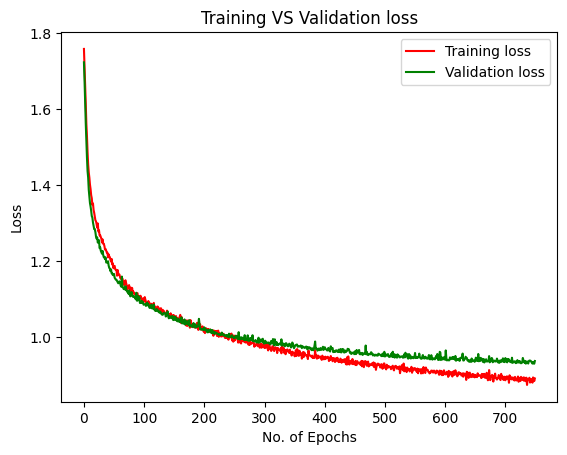

In [18]:
plt.plot(history.history['loss'], 'r', label='Training loss')
if VALIDATION_FRAC > 0:
    plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

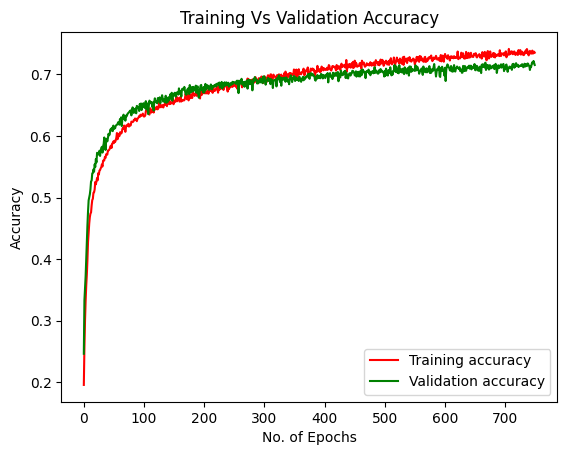

In [19]:
plt.plot(history.history['acc'], 'r', label='Training accuracy')
if VALIDATION_FRAC > 0:
    plt.plot(history.history['val_acc'], 'g', label='Validation accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
print('--------------- model fitted ----------------------')

--------------- model fitted ----------------------


In [21]:
def check_validation():
    y_true = []
    y_predict = []
    for index in range(len(valid_data)):
        train_batch, target_batch = valid_data[index]
        predict = model.predict(train_batch)
        decision = Target.make_decision(predict)
        target_decision = Target.make_decision(target_batch)
        for i in range(len(decision)):
            y_predict.append(decision[i])
            y_true.append(target_decision[i])
    print('accuracy =', accuracy_score(y_true, y_predict))

In [22]:
%%time

if VALIDATION_FRAC > 0:
    if USE_GPU:
        with tf.device('/gpu:0'):
            check_validation()
    else:
        check_validation()

4/4 [==============================] - 0s 3ms/step
accuracy = 0.7153558052434457
CPU times: user 4.58 s, sys: 188 ms, total: 4.76 s
Wall time: 4.69 s


In [23]:
print('mem usage =', size_2_str(get_mem_usage()))
del train_eeg_loader,train_target_loader

mem usage = 21 KB


In [24]:
def build_test_data(ids, eeg_loader, eeg_id_loader):
    eeg = EEG.create_model_input(ids, eeg_loader, BATCH_SIZE)
    eeg_id = EEG_ID.create_model_data(ids, eeg_id_loader, BATCH_SIZE)
    
    eeg_eeg_id_seq = DataUtils.JoinSequence(eeg, eeg_id)
    return DataUtils.AsKerasSequence(eeg_eeg_id_seq)

In [25]:
test_size, test_eeg_loader, _, test_eeg_id_loader = Data.load_test()
test_data = build_test_data(
    list([x for x in range(test_size)]), 
    test_eeg_loader, 
    test_eeg_id_loader
)

In [26]:
%%time

output = []
for index in range(len(test_data)):
    batch, eeg_ids = test_data[index]
    predict = model.predict(batch)
    for i in range(len(eeg_ids)):
        res = [*eeg_ids[i]]
        res.extend(predict[i].tolist())
        output.append(res)
output = pd.DataFrame(
    data = output,
    columns = ['eeg_id'] + Target.FEATURES
)
output.to_csv('submission.csv', index = False)


1/1 [==============================] - 0s 320ms/step
CPU times: user 321 ms, sys: 19.6 ms, total: 340 ms
Wall time: 598 ms


In [27]:
model.save('eeg_model.keras')

In [28]:
print('--------------- submission done ----------------------')

--------------- submission done ----------------------
